In [ ]:
%pip install cartopy            #install required packages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 84.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle

In [ ]:
#load dataset and check information

f = xr.open_dataset('/content/rlut_CERES-EBAF_L3B_Ed2-8_200003-201404.nc')
#print(f)                            #check information of the datasets
print(f.dims)
print(f.data_vars)
print(f.coords)
print(f.attrs)

Frozen({'time': 170, 'bnds': 2, 'lat': 180, 'lon': 360})
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    rlut       (time, lat, lon) float32 ...
Coordinates:
  * time     (time) datetime64[ns] 2000-03-16T12:00:00 2000-04-16 ... 2014-04-16
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
{'institution': 'NASA Langley Research Center, Hampton, Va, USA', 'institute_id': 'NASA-LaRC', 'experiment_id': 'obs', 'source': 'CERES retrievals', 'model_id': 'Obs-CERES-EBAF', 'contact': 'Norman Loeb, norman.g.loeb@nasa.gov', 'references': 'http://ceres.larc.nasa.gov/cmip5_data.php', 'tracking_id': '5da4db80-31cb-4340-b5e1-0fbacaee873a', 'instrument': 'CERES', 'processing_version': 'Ed2.8', 'processing_level': 'L3B', 'mip_specs': 'CMIP5', 'data_structure': 'grid', 'source_type': 'satellite_retr

In [ ]:
olr = f['rlut']                                  #our target variable
print(olr)
for dim_name in olr.dims:                        #print the dimensions
    print(f'Dimension name: {dim_name}')
    print(f'Dimension data: {olr[dim_name]}')
    print("-----------------------")

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


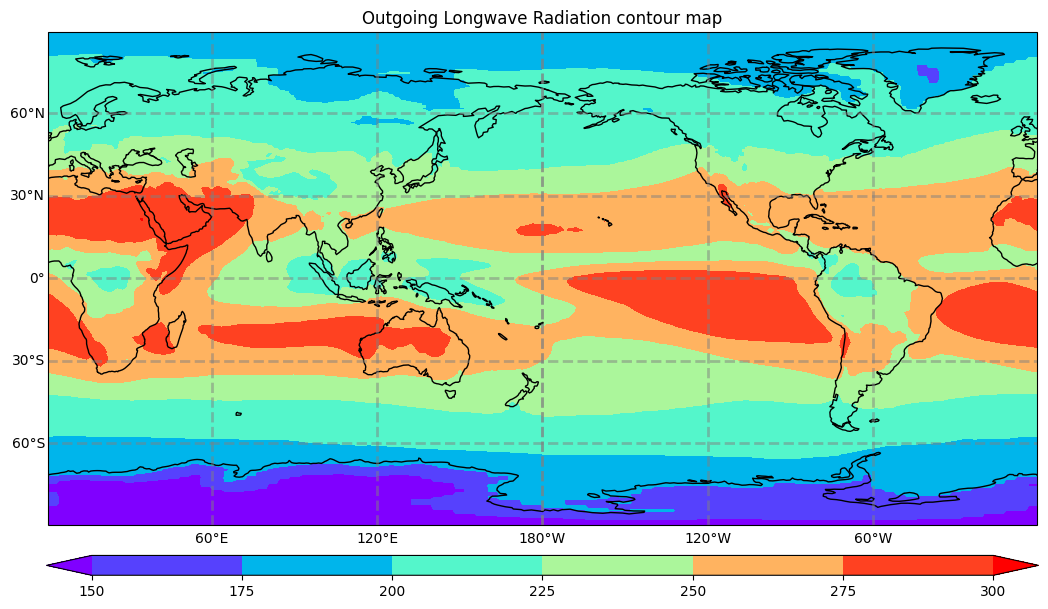

In [ ]:
#plot global contour

olr = f['rlut'].sel(time = slice('2001','2013'))                                            #select complete years
olr_mean = olr.mean('time')                                                                 #calculate temporal average
fig = plt.figure(figsize=(16, 8))                                                           #create an empty figure
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude = 180))         #add a subplot with projection
cf = ax.contourf( olr_mean.lon, olr_mean.lat, olr_mean, extend='both', cmap = plt.cm.rainbow, transform=ccrs.PlateCarree())    #plot contour
cb = plt.colorbar(cf, orientation='horizontal', shrink=0.8, aspect=50, pad=0.05)            #add colorbar
ax.set_title('Outgoing Longwave Radiation contour map')                                     #set title
ax.add_feature(cfeature.COASTLINE)                                                          #add coastlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')              #add gridlines
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])                                   #set positions of ticks
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER                                                         #set tick format
gl.yformatter = LATITUDE_FORMATTER
plt.show()

In [ ]:
print(np.sum(np.where(np.isnan(olr),1,0)))                            #check if there are missing values

0


In [ ]:
#trend calculation

olr_yearmean = olr.groupby('time.year').mean('time')                #calculate annual averages
olr_pixelmean = olr_yearmean.mean(axis=0)                           #calculate temporal mean for each pixel
sxy = np.zeros(olr_pixelmean.shape)                                 #in linear regression, slope is sxy/sxx
sxx = np.zeros(olr_pixelmean.shape)
x_mean = (olr_yearmean.shape[0] + 1) / 2                            #x average
for i in range(olr_yearmean.shape[0]):                              #calculate sxy and sxx for each pixel
    sxy += (olr_yearmean[i,:,:] - olr_pixelmean) * (i + 1 - x_mean)
    sxx += np.ones(olr_pixelmean.shape) * (i + 1 - x_mean)**2

olr_slope = sxy / sxx                                               #obtain the slope matrix

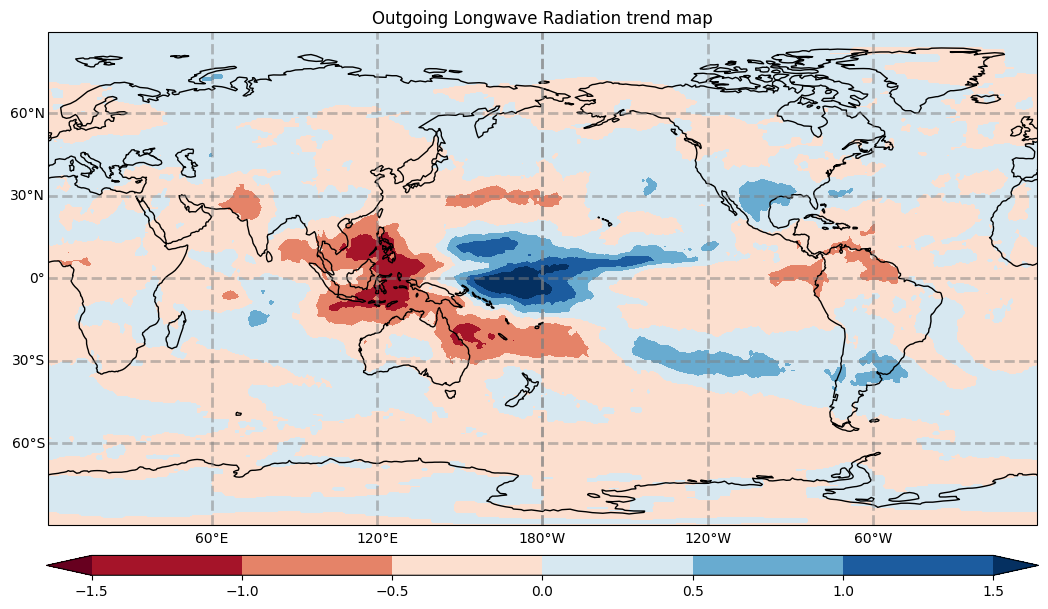

In [ ]:
#plot trend map

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude = 180))
cf = ax.contourf( olr_mean.lon, olr_mean.lat, olr_slope, [-1.5, -1.0, -0.5, 0, .5, 1, 1.5], extend='both', cmap = plt.cm.RdBu, transform=ccrs.PlateCarree())
cb = plt.colorbar(cf, orientation='horizontal', shrink=0.8, aspect=50, pad=0.05)
ax.set_title('Outgoing Longwave Radiation trend map')
ax.add_feature(cfeature.COASTLINE)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
plt.show()

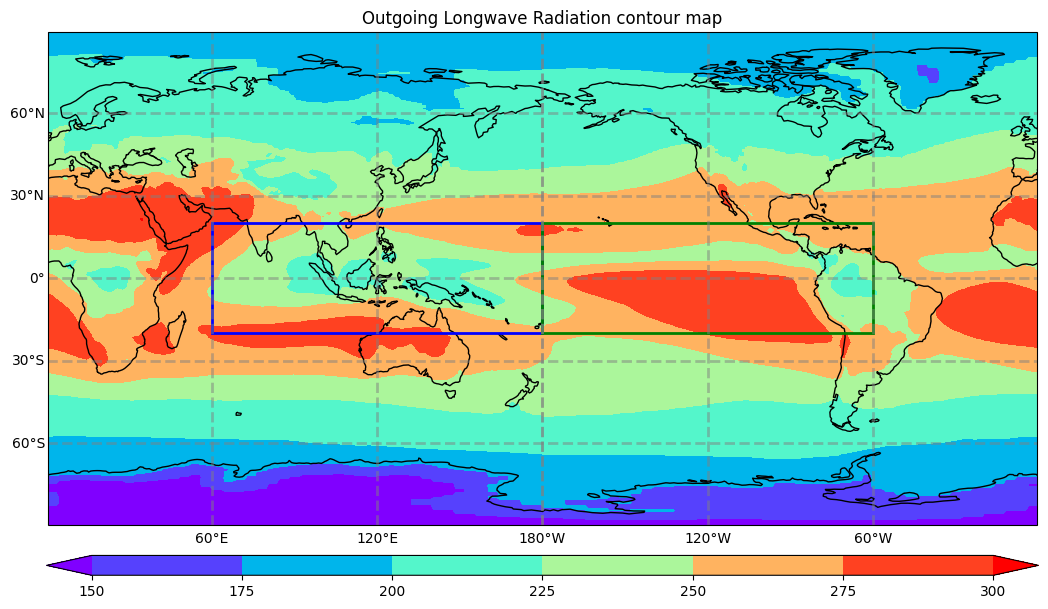

In [ ]:
#area selection

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude = 180))
cf = ax.contourf( olr_mean.lon, olr_mean.lat, olr_mean, extend='both', cmap = plt.cm.rainbow, transform=ccrs.PlateCarree())
cb = plt.colorbar(cf, orientation='horizontal', shrink=0.8, aspect=50, pad=0.05)
ax.set_title('Outgoing Longwave Radiation contour map')
ax.add_feature(cfeature.COASTLINE)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#area 1
lon0, lon1, lat0, lat1 = [60, 180, -20, 20]                                                           #selected area 1
start_point = (lon0, lat0)                                                                            #plot selected region on figure
selcted_area_1 = Rectangle(start_point, lon1-lon0, lat1-lat0, linewidth=2, linestyle='-', zorder=2,
                           edgecolor='blue', facecolor='none', transform=ccrs.PlateCarree())
ax.add_patch(selcted_area_1)

#area 2
lon0, lon1, lat0, lat1 = [180, 300, -20, 20]
start_point = (lon0, lat0)
selcted_area_2 = Rectangle(start_point, lon1-lon0, lat1-lat0, linewidth=2, linestyle='-', zorder=2,
                           edgecolor='green', facecolor='none', transform=ccrs.PlateCarree())
ax.add_patch(selcted_area_2)
plt.show()

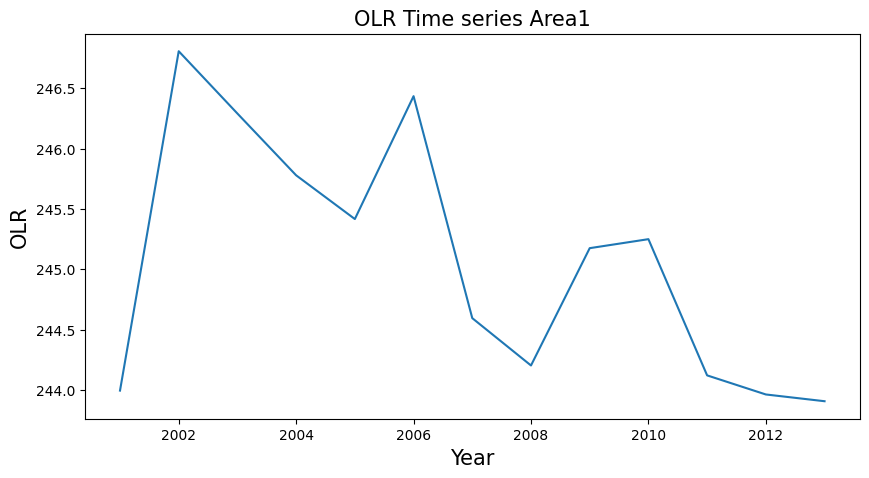

In [ ]:
#plot time series of spatiotemporal average OLR in area 1

lon0, lon1, lat0, lat1 = [60, 180, -20, 20]
olr_selected_1 = olr.sel(lon = slice(lon0,lon1), lat = slice(lat0,lat1))                          #select area 1
olr_selected_ymean_1 = olr_selected_1.groupby('time.year').mean('time').mean('lat').mean('lon')   #time series of spatiotemporal average
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(olr_selected_ymean_1.year, olr_selected_ymean_1)                                          #plot time series
plt.xlabel('Year', fontsize=15)
plt.ylabel('OLR', fontsize=15)
plt.title('OLR Time series Area1', fontsize=15)
plt.show()

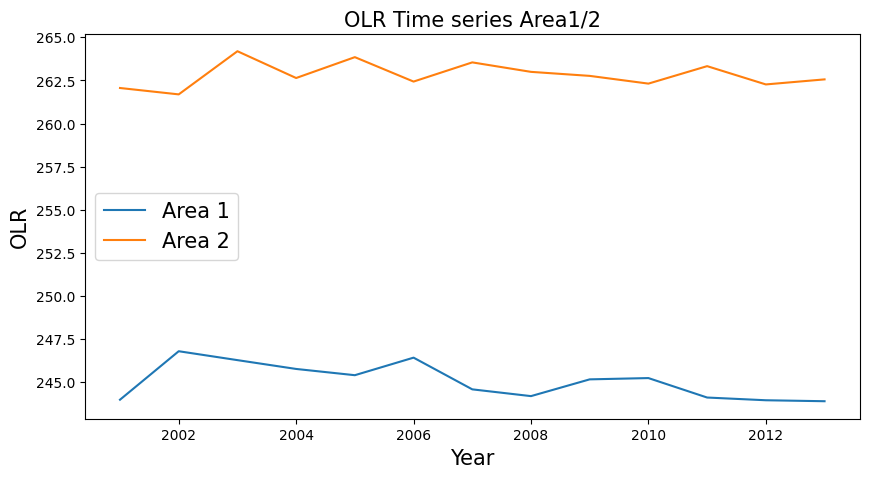

In [ ]:
#plot and compare time series in the 2 areas

#plot and compare time series in the 2 areas
ytme=[1992, 2000, 2010]
lon0, lon1, lat0, lat1 = [180, 300, -20, 20]
olr_selected_2 = olr.sel(lon=slice(lon0, lon1), lat=slice(lat0, lat1))
olr_selected_ymean_2 = olr_selected_2.groupby('time.year').mean('time').mean('lat').mean('lon')
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ytme, olr_selected_ymean_1, label='Area 1')
ax.plot(ytme, olr_selected_ymean_2, label='Area 2')
plt.title('OLR Time series Area1/2', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('OLR', fontsize=15)
plt.legend(loc='center left', fontsize=15)
plt.show()